This notebook is inspired by the work under
https://github.com/nicknochnack/Stock-and-Crypto-News-ScrapingSummarizationSentiment <br>
https://www.youtube.com/watch?v=YbKnsJQKazA <br>

Unfortunately the following part of the code <br>

search_url = "https://www.google.com/search?q=yahoo+finance+{}&tbm=nws".format(ticker)<br>
r = requests.get(search_url)

had log-in + cookies problems. I found a work around by using the pygooglenews library.




### 1. Import libraries


In [1]:

# run this without comment to install transformers

#!pip install transformers

# run this this without comment to install pygooglenews

#!pip install pygooglenews --upgrade

In [17]:

from transformers import PegasusTokenizer, PegasusForConditionalGeneration
from transformers import PegasusTokenizer, PegasusForConditionalGeneration, TFPegasusForConditionalGeneration
from bs4 import BeautifulSoup
import requests
#from GoogleNews import GoogleNews 
from pygooglenews import GoogleNews

from transformers import pipeline 
import csv
import pandas as pd
import seaborn as sns


### 2. Setup Summarization Model


In [4]:
model_name = "human-centered-summarization/financial-summarization-pegasus"
tokenizer = PegasusTokenizer.from_pretrained(model_name)
model = PegasusForConditionalGeneration.from_pretrained(model_name)

### 3. Building Sentiment Pipeline

In [5]:
#### Use googlenews to directly find the links to yahoo finance article
query = 'yahoo finance btc' # change this for other sources

# default GoogleNews instance
gn = GoogleNews(lang = 'en', country = 'US')

# find all latest news about the query 
s = gn.search(query)


In [6]:
# we find the links to the articles by looking at s -> entry -> link
s

{'feed': {'generator_detail': {'name': 'NFE/5.0'},
  'generator': 'NFE/5.0',
  'title': '"yahoo finance btc" - Google News',
  'title_detail': {'type': 'text/plain',
   'language': None,
   'base': '',
   'value': '"yahoo finance btc" - Google News'},
  'links': [{'rel': 'alternate',
    'type': 'text/html',
    'href': 'https://news.google.com/search?q=yahoo+finance+btc&ceid=US:en&hl=en-US&gl=US'}],
  'link': 'https://news.google.com/search?q=yahoo+finance+btc&ceid=US:en&hl=en-US&gl=US',
  'language': 'en-US',
  'publisher': 'news-webmaster@google.com',
  'publisher_detail': {'email': 'news-webmaster@google.com'},
  'rights': '2021 Google Inc.',
  'rights_detail': {'type': 'text/plain',
   'language': None,
   'base': '',
   'value': '2021 Google Inc.'},
  'updated': 'Mon, 17 May 2021 19:26:11 GMT',
  'updated_parsed': time.struct_time(tm_year=2021, tm_mon=5, tm_mday=17, tm_hour=19, tm_min=26, tm_sec=11, tm_wday=0, tm_yday=137, tm_isdst=0),
  'subtitle': 'Google News',
  'subtitle_det

#### Example inspection and summarization of first article


In [7]:
# inspect the first element

s['entries'][0]['link']

'https://finance.yahoo.com/news/bitcoin-hits-three-month-low-044552615.html'

In [8]:
# extract and inspect the first 400 words in the first article
url = s['entries'][0]['link'] #read the url
r = requests.get(url) #grab the web page 
soup = BeautifulSoup(r.text, 'html.parser') 
paragraphs = soup.find_all('p') #find all paragraphs
text = [paragraph.text for paragraph in paragraphs]
words = ' '.join(text).split(' ')[:400] 
ARTICLE = ' '.join(words)[:400] #cut the first 400 words for the summarization algorithm

ARTICLE

"By Tom Westbrook, Kevin Buckland and Gertrude Chavez-Dreyfuss NEW YORK/LONDON (Reuters) -Bitcoin fell to a three-month low on Monday in a volatile session that saw investors selling and buying the digital currency after Tesla boss Elon Musk tweeted about the carmaker's bitcoin holdings. Bitcoin fell to as low as $42,185, its lowest since Feb. 8, and was last down 6.2% at $43,564. In his latest twe"

In [9]:
# 1. Convert ARTICLE to pytorch ('pt') tensor
# 2. Find "tensor summary" with lenght 55
# 3. decode the tensor to text form

input_ids = tokenizer.encode(ARTICLE, return_tensors ='pt') # return pythorch tensors
output = model.generate(input_ids, max_length = 55, early_stopping = True) #summary in 55 words. Pegasus Model summarises the tensors
summary = tokenizer.decode(output[0], skip_special_tokens = True) # gives the output from tensor to text
summary



'Musk says Tesla has a small amount of the digital currency.'

#### Do the same for all articles

In [10]:

# extract all URLs and put to a list

URLs = []
for i in range(0,len(s['entries'])):
   URLs.append(s['entries'][i]['link'])

ARTICLES = [] # list of articles
for url in URLs:
    r = requests.get(url) # grasp the page from the url
    soup = BeautifulSoup(r.text, 'html.parser') 
    paragraphs = soup.find_all('p') # find all paragraph with beautifulsoup
    text = [paragraph.text for paragraph in paragraphs]
    words = ' '.join(text).split(' ')[:400]
    ARTICLE = ' '.join(words)[:400]
    ARTICLES.append(ARTICLE)

In [11]:
# generate summaries --- it may take a bit
summaries = []
for ARTICLE in ARTICLES:
   input_ids = tokenizer.encode(ARTICLE, return_tensors ='pt') # return pythorch tensors
   output = model.generate(input_ids, max_length = 55, early_stopping = True) #summary in 55 words. Pegasus Model summarises the tensors
   summary = tokenizer.decode(output[0], skip_special_tokens = True) # gives the output from tensor to text
   summaries.append(summary)


# print out one of the summaries
summaries[1]

'Tesla no longer accepts cryptocurrency as payment for its products'

In [12]:
sentiment = pipeline('sentiment-analysis')

# attach the sentiment to the summaries
scores = sentiment(summaries)

In [13]:
# Function to create final csv output
def create_output_array(summaries, scores, urls):
    output = []
    #for ticker in monitored_tickers:
    for counter in range(len(summaries)):#[ticker])):
            output_this = [
                
                summaries[counter],
                scores[counter]['label'],
                scores[counter]['score'],
                urls[counter]
            ]
            output.append(output_this)
    return output

In [14]:
final_output = create_output_array(summaries, scores, URLs)
final_output

final_output.insert(0, [ 'Summary', 'Label', 'Confidence', 'URL'])

In [15]:
# write results to csv
with open('assetsummaries.csv', mode='w', newline='') as f:
    csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    csv_writer.writerows(final_output)

In [21]:
# create a dataframe
df = pd.DataFrame(final_output[1:], columns = final_output[0])

In [26]:
df

,Summary,Label,Confidence,URL
0,Musk says Tesla has a small amount of the digi...,NEGATIVE,0.988408,https://finance.yahoo.com/news/bitcoin-hits-th...
1,Tesla no longer accepts cryptocurrency as paym...,NEGATIVE,0.999654,https://finance.yahoo.com/news/crypto-long-sho...
2,"Reversing a 2.96% gain from the previous week,...",NEGATIVE,0.998251,https://finance.yahoo.com/news/bitcoin-ethereu...
3,The cryptocurrency approached initial support ...,NEGATIVE,0.999696,https://finance.yahoo.com/news/bitcoin-holds-s...
4,Largest cryptocurrency continues to trade lowe...,NEGATIVE,0.999495,https://finance.yahoo.com/news/latest-bitcoin-...
...,...,...,...,...
95,"Bitcoin options expire on Friday, with maximum...",NEGATIVE,0.982226,https://finance.yahoo.com/news/bitcoin-news-ro...
96,"Decentralised finance, also known as DeFi, is ...",POSITIVE,0.998360,https://uk.finance.yahoo.com/news/bitcoin-ethe...
97,Some major coins like Ether and Bitcoin also f...,NEGATIVE,0.999662,https://finance.yahoo.com/video/bitcoin-prices...
98,The cost to fund long positions in the market ...,NEGATIVE,0.990308,https://finance.yahoo.com/news/bitcoin-recover...


In [29]:
# set up weighted sentiment
sentim = []
for i in df.index.tolist():
   if df['Label'][i] == 'NEGATIVE':
        sentim.append( -1.0 * df['Confidence'][i])
   else:
        sentim.append( 1.0 * df['Confidence'][i])

In [30]:
df['sentim'] = sentim

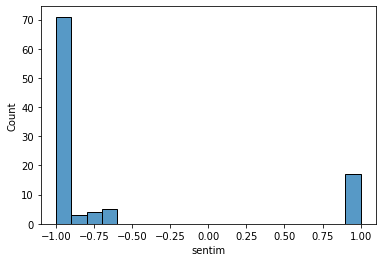

In [31]:
# plot weighted sentiment distribution
sns.histplot(data=df, x="sentim")